This notebook demonstrates the CUDA-accelerated likelihood function from the heron package.
This likelihood function incorporates the variance from the waveform models in heron as well as the variance from the data.

In [1]:
import math
import torch

from heron.models.torchbased import HeronCUDA
from heron.matched import CudaLikelihood

from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

Set up the model.

In [2]:
generator = HeronCUDA()

For a smple demonstration, inject a signal into Gaussian noise.

In [14]:
noise = 5e-19*torch.randn(1000)
signal = generator.time_domain_waveform({'mass ratio': 0.7}, times=np.linspace(-0.02, 0.02, 1000))

In [15]:
from elk.waveform import Timeseries

In [16]:
detection = Timeseries(data=(torch.tensor(signal[0].data) + noise), times=signal[0].times)

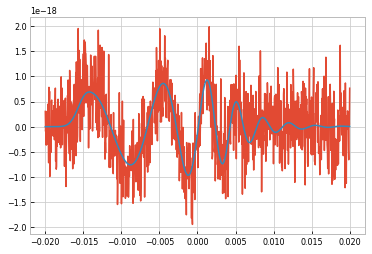

In [17]:
plt.plot(detection.times, detection.data)
plt.plot(signal[0].times, signal[0].data)

Set up the likelihood object.

In [18]:
l = CudaLikelihood(generator, 
                   data = detection,
                   psd=noise.cuda().rfft(1),
                  )

In [19]:
#%%timeit
masses = np.linspace(0.5,1.0,200)
likes = [l({'mass ratio': m}) for m in masses]

In [20]:
masses[np.argmax(likes)]

0.7738693467336684

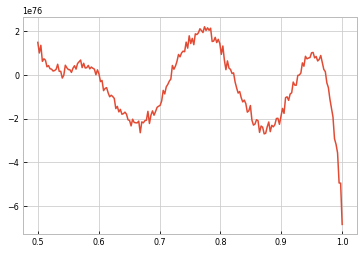

In [21]:
#plt.axvline([0.7], color='k')
plt.plot(masses, likes)

In [43]:
l({'mass ratio': 0.2101})

tensor(-2.0416e+36, device='cuda:0', dtype=torch.float64)

In [44]:
l({'mass ratio': 0.92})

tensor(1.7698e+35, device='cuda:0', dtype=torch.float64)

In [45]:
l({'mass ratio': 1.0})

tensor(1.0497e+35, device='cuda:0', dtype=torch.float64)

In [44]:
size = 1000

times = np.linspace(-2, 2, 1000)
q = 0.9#masses[np.argmax(likes)]

points = np.ones((1000,2))
points[:,0] = times
points[:,1] = points[:,1] * np.log(q) * 100

test_x = torch.tensor(points).float()
test_x = test_x.cuda()

In [45]:
#%%timeit
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f_preds = model(test_x)
    y_preds = likelihood(f_preds)

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 2 and 8 in dimension 1 at /pytorch/aten/src/THC/generic/THCTensorMath.cu:71

In [ ]:
with torch.no_grad():
    lower, upper = y_preds.confidence_region()
    f, ax = plt.subplots(1,1, dpi=300)
    ax.plot(test_x[:,0].cpu().numpy(), f_preds.mean.cpu().numpy()/1e21)
    #samples = y_preds.sample_n(100)
    #for sample in samples:
    #    ax.plot(test_x[:,0].numpy(), sample.numpy()[:,0], alpha=0.01, color='r')
    #    ax.plot(test_x[:,0].numpy(), sample.numpy()[:,1], alpha=0.01, color='b')
    #ax.plot(training_x[:,0].cpu(), training_y.cpu()/1e21, '+')
    ax.fill_between(test_x[:,0].cpu().numpy(), lower.cpu().numpy()/1e21, upper.cpu().numpy()/1e21, alpha=0.5)

In [ ]:
generator.parameters

In [ ]:
# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.1)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


epochs_iter = tqdm.tqdm_notebook(range(training_iterations), desc="Epoch")
for i in epochs_iter:
    optimizer.zero_grad()
    # Output from model
    output = model(training_x)
    # Calc loss and backprop gradients
    loss = -mll(output, training_y).cuda()
    loss.backward()
    optimizer.step()